In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt



In [2]:
import tarfile
import os

tar_path = "twitter.tar"
extract_path = "twitter_ego"

if not os.path.exists(extract_path):
    with tarfile.open(tar_path, "r") as tar:
        tar.extractall(path=extract_path)

print("Extraction terminée")

Extraction terminée


In [3]:
nodeId = "12831" 

# Edges
edges = pd.read_csv(
    f"twitter_ego/twitter/{nodeId}.edges",
    sep=" ",
    header=None,
    names=["source", "target"]
)

# Features
feat = pd.read_csv(f"twitter_ego/twitter/{nodeId}.feat", sep=" ", header=None)
egofeat = pd.read_csv(f"twitter_ego/twitter/{nodeId}.egofeat", sep=" ", header=None)

# Feature names
featnames = pd.read_csv(f"twitter_ego/twitter/{nodeId}.featnames", sep=" ", header=None)
# Circles
circles = {}
with open(f"twitter_ego/twitter/{nodeId}.circles") as f:
    for line in f:
        parts = line.strip().split()
        circles[parts[0]] = parts[1:]


In [4]:
G = nx.DiGraph()

# Ajouter les arêtes entre voisins
G.add_edges_from(edges.values)

# Ajouter l'ego node
ego_node = nodeId
G.add_node(ego_node)

# L'ego suit tous les nœuds de son ego network
neighbors = set(edges["source"]).union(edges["target"])
for n in neighbors:
    G.add_edge(ego_node, n)

print("Nombre de nœuds :", G.number_of_nodes())
print("Nombre d'arêtes :", G.number_of_edges())


Nombre de nœuds : 237
Nombre d'arêtes : 2714


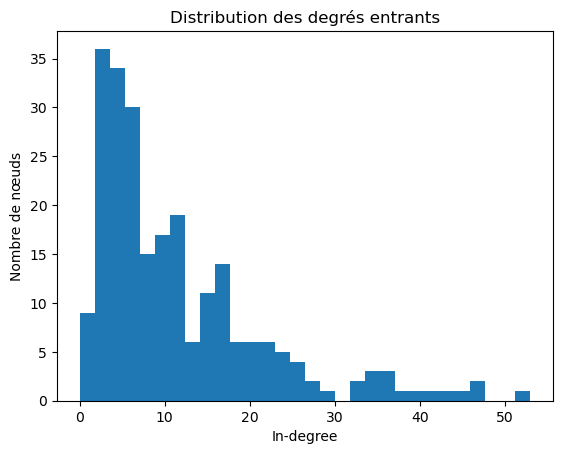

In [5]:
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

plt.hist(in_degrees.values(), bins=30)
plt.title("Distribution des degrés entrants")
plt.xlabel("In-degree")
plt.ylabel("Nombre de nœuds")
plt.show()

In [6]:
pagerank = nx.pagerank(G)
# Top 10 nœuds les plus influents
sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]



[(51518017, 0.018901120953118015),
 (180505807, 0.016620648236492817),
 (174958347, 0.016220651271336876),
 (380, 0.015359251477501255),
 (586, 0.015299515317817028),
 (6735, 0.014567707497407368),
 (11178592, 0.014034730934954071),
 (14231571, 0.013972708624004553),
 (2735631, 0.013451630980669782),
 (528, 0.013058732038499575)]

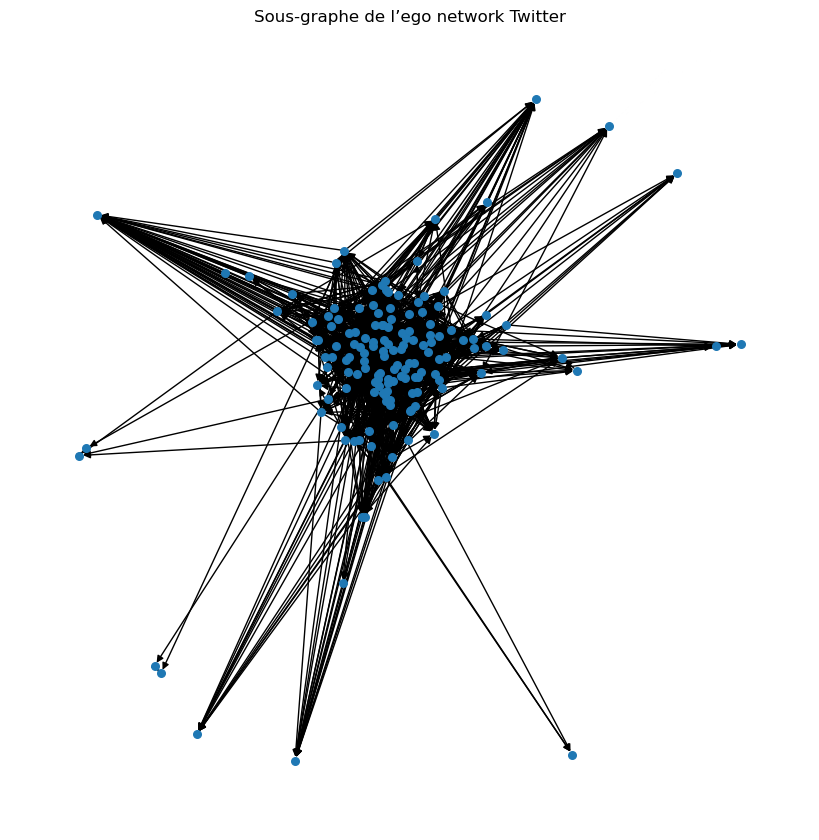

In [7]:
sub_nodes = list(G.nodes())[:150]
H = G.subgraph(sub_nodes)

plt.figure(figsize=(8, 8))
nx.draw(H, node_size=30, with_labels=False)
plt.title("Sous-graphe de l’ego network Twitter")
plt.show()


In [8]:
G = nx.relabel_nodes(G, lambda x: str(x))
ego_node = str(ego_node)

# Nœuds communs entre le graphe et les features
common_nodes = list(set(G.nodes()).intersection(feat.index))

print("Nœuds avec features :", len(common_nodes))
print("Nœuds sans features :", G.number_of_nodes() - len(common_nodes))

G = G.subgraph(common_nodes).copy()
feat = feat.loc[common_nodes]


Nœuds avec features : 0
Nœuds sans features : 237


In [9]:
!pip install node2vec

In [10]:
from node2vec import Node2Vec

node2vec = Node2Vec(
    G,
    dimensions=64,
    walk_length=30,
    num_walks=200,
    workers=1  # IMPORTANT
)


model = node2vec.fit(window=10, min_count=1)
# Récupérer les embeddings
embeddings = {
    node: model.wv[str(node)]
    for node in G.nodes()
}


Computing transition probabilities: 0it [00:00, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:00<00:00, 1503334.77it/s]


RuntimeError: you must first build vocabulary before training the model

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array(list(embeddings.values()))

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

cluster_map = dict(zip(G.nodes(), clusters))


In [ ]:
node_labels = {}

for circle, nodes in circles.items():
    for n in nodes:
        node_labels[n] = circle


In [ ]:
X_cls, y_cls = [], []

for node, label in node_labels.items():
    if node in embeddings:
        X_cls.append(embeddings[node])
        y_cls.append(label)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_cls)

X_cls = np.array(X_cls)
y_cls = np.array(y_cls)


print("X_cls shape:", X_cls.shape)
print("y_cls length:", len(y_cls))
print("y_cls:", y_cls)




X_cls shape: (1, 64)
y_cls length: 1
y_cls: ['1']
